**Loading and Parsing Transaction Data**

In this step, we're loading the raw transaction data from the file user-wallet-transactions.json. Since the file might be formatted in different ways (either a JSON array or JSON lines), we added logic to handle both scenarios safely.

First, we read the entire file content and check if it starts with [. If it does, we assume it's a proper JSON array and load it using json.loads().

If not, we treat it as a "JSON Lines" file — meaning each line is an individual JSON object. We then loop through each line, try to parse it, and add it to our dataset.

We’ve also included error handling so that if any line is broken or malformed, it will be skipped without stopping the entire process.

Finally, we print how many transactions were successfully loaded to confirm that the data was read properly.

This step ensures that we can work with a clean list of transactions, regardless of the input format or occasional data issues.

In [10]:
import json


try:
    with open("user-wallet-transactions.json", "r") as file:
        content = file.read()
        if content.strip().startswith("["):
            data = json.loads(content)
        else:
            data = []
            with open("user-wallet-transactions.json", "r") as f2:
                for line in f2:
                    line = line.strip()
                    if line:
                        try:
                            data.append(json.loads(line))
                        except json.JSONDecodeError:
                            continue
except Exception as e:
    print("Failed to load JSON:", e)
    data = []

print(f"Loaded {len(data)} transactions.")


Loaded 100000 transactions.


** Feature Engineering & Credit Scoring (Rule-Based)**

Once the transaction data was loaded, I started by analyzing the behavior of each wallet by aggregating its activity. For every wallet, I calculated:

How many times it deposited, borrowed, repaid, redeemed, or was liquidated.

The total amounts deposited, borrowed, and repaid (converted into USD).

The first and last time the wallet interacted with the protocol.

The total number of transactions it made.

To make sense of token amounts (since different tokens have different decimal values), I converted them to USD using the provided token price and decimal info. This gave me standardized values to work with across tokens like USDC, DAI, WETH, etc.

I also calculated the number of days each wallet was active, which gave a sense of how consistently it used the protocol.

Scoring Logic
To assign a credit score between 0 and 1000, I created a simple rule-based function that tries to reflect good or risky behavior.

Here’s how the scoring works:

Everyone starts with a base score of 500.

Wallets are rewarded for:

Large deposits and repayments (up to +100 points each).

Making many repayments (up to +50 points).

Being active for a longer time (up to +100 points).

Wallets are penalized for:

Borrowing without ever repaying (−100 points).

Getting liquidated (−20 points per incident).

Very low activity (less than or equal to 2 transactions results in a −50 penalty).

After applying this scoring logic to all wallets, I exported the final credit scores to a CSV file called wallet_scores.csv. These scores are then used for further analysis and as a training target for machine learning models.

In [11]:
import json
import pandas as pd
from datetime import datetime
from collections import defaultdict
try:
    with open("user-wallet-transactions.json", "r") as file:
        content = file.read()
        if content.strip().startswith("["):
            data = json.loads(content)
        else:
            data = []
            with open("user-wallet-transactions.json", "r") as f2:
                for line in f2:
                    line = line.strip()
                    if line:
                        try:
                            data.append(json.loads(line))
                        except json.JSONDecodeError:
                            continue
except Exception as e:
    print("Failed to load JSON:", e)
    data = []

print(f"Loaded {len(data)} transactions.")

wallets = defaultdict(lambda: {
    'deposit_count': 0, 'borrow_count': 0, 'repay_count': 0,
    'redeem_count': 0, 'liquidation_count': 0,
    'total_deposit_usd': 0, 'total_borrow_usd': 0, 'total_repay_usd': 0,
    'first_tx_time': None, 'last_tx_time': None, 'tx_count': 0
})

token_decimals = {
    'USDC': 6, 'USDT': 6, 'DAI': 18,
    'WMATIC': 18, 'WETH': 18, 'WBTC': 8,
}
for tx in data:
    wallet = tx.get('userWallet')
    action = tx.get('action')
    action_data = tx.get('actionData', {})

    if not wallet or not action:
        continue

    amount = float(action_data.get('amount', 0))
    price = float(action_data.get('assetPriceUSD', 0))
    symbol = action_data.get('assetSymbol', 'UNKNOWN')
    decimals = token_decimals.get(symbol, 18)
    amount_usd = (amount / (10 ** decimals)) * price
    timestamp = datetime.utcfromtimestamp(tx['timestamp'])

    if action == 'deposit':
        wallets[wallet]['deposit_count'] += 1
        wallets[wallet]['total_deposit_usd'] += amount_usd
    elif action == 'borrow':
        wallets[wallet]['borrow_count'] += 1
        wallets[wallet]['total_borrow_usd'] += amount_usd
    elif action == 'repay':
        wallets[wallet]['repay_count'] += 1
        wallets[wallet]['total_repay_usd'] += amount_usd
    elif action == 'redeemunderlying':
        wallets[wallet]['redeem_count'] += 1
    elif action == 'liquidationcall':
        wallets[wallet]['liquidation_count'] += 1

    wallets[wallet]['tx_count'] += 1
    if wallets[wallet]['first_tx_time'] is None or timestamp < wallets[wallet]['first_tx_time']:
        wallets[wallet]['first_tx_time'] = timestamp
    if wallets[wallet]['last_tx_time'] is None or timestamp > wallets[wallet]['last_tx_time']:
        wallets[wallet]['last_tx_time'] = timestamp
wallet_df = pd.DataFrame.from_dict(wallets, orient='index')
wallet_df.index.name = 'wallet'
wallet_df.reset_index(inplace=True)
wallet_df['activity_days'] = (
    wallet_df['last_tx_time'] - wallet_df['first_tx_time']
).dt.days + 1
def calculate_credit_score(row):
    score = 500

    score += min(row['total_deposit_usd'] / 1000, 100)
    score += min(row['total_repay_usd'] / 1000, 100)
    score += min(row['repay_count'] * 5, 50)
    score += min(row['activity_days'], 100)

    if row['borrow_count'] > 0 and row['repay_count'] == 0:
        score -= 100
    score -= row['liquidation_count'] * 20
    if row['tx_count'] <= 2:
        score -= 50

    return int(max(0, min(1000, score)))

wallet_df['credit_score'] = wallet_df.apply(calculate_credit_score, axis=1)

wallet_df[['wallet', 'credit_score']].to_csv("wallet_scores.csv", index=False)

print("Scoring complete. Output saved to wallet_scores.csv")


Loaded 100000 transactions.
Scoring complete. Output saved to wallet_scores.csv


**Credit Scoring with K-Means Clustering**

In this step, I used K-Means clustering to group wallets based on their behavior — like how much they deposited, repaid, how often they were liquidated, and how long they were active.

After scaling the features, I grouped the wallets into 5 clusters. Then, I assigned a credit score to each cluster depending on how responsible the behavior looked — for example, wallets in the best-performing cluster got a score of 800, while the riskiest ones got 50.

This helped build a data-driven scoring system without using any predefined labels.



In [12]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

features = wallet_df[['total_deposit_usd', 'total_repay_usd', 'repay_count', 'liquidation_count', 'activity_days']]
X_scaled = StandardScaler().fit_transform(features)

kmeans = KMeans(n_clusters=5, random_state=0)
wallet_df['cluster'] = kmeans.fit_predict(X_scaled)
cluster_to_score = {
    0: 800,
    1: 600,
    2: 400,
    3: 200,
    4: 50
}
wallet_df['credit_score'] = wallet_df['cluster'].map(cluster_to_score)


**ML-Based Credit Scoring with Random Forest**


In this step, I trained a Random Forest Regressor to predict credit scores using behavioral features like deposit amount, repayment activity, and liquidation count.

I used the credit scores (from KMeans or rule-based logic) as training labels. After training the model, I used it to assign a new score to each wallet — stored in a column called ml_credit_score.

This helps create a more flexible and data-driven scoring system that can adapt as new wallet data comes in.

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X = wallet_df[['total_deposit_usd', 'total_repay_usd', 'repay_count', 'liquidation_count', 'activity_days']]
y = wallet_df['credit_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
wallet_df['ml_credit_score'] = model.predict(X)


In [15]:
wallet_df[['wallet', 'credit_score', 'ml_credit_score']]

,wallet,credit_score,ml_credit_score
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,600,600.0
1,0x000000000051d07a4fb3bd10121a343d85818da6,600,600.0
2,0x000000000096026fb41fc39f9875d164bd82e2dc,600,600.0
3,0x0000000000e189dd664b9ab08a33c4839953852c,50,50.0
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,50,50.0
...,...,...,...
3492,0x06185db89f5c8ef5e5a0abc95c5cb69b54c33f30,600,600.0
3493,0x06189341e523a52ae10c4bd4a7774371fac1b249,600,600.0
3494,0x0618c450370822c5cb25ec143a3008230d8e2c12,600,600.0
3495,0x0618e615c8c9b5efc8c8eadc68be7182bdc455e2,600,600.0


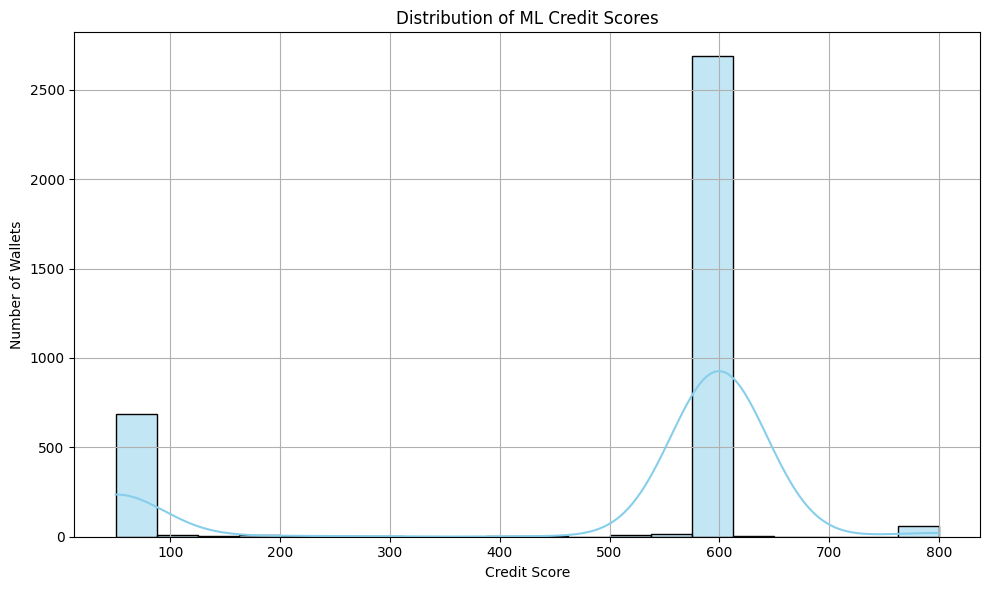

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(wallet_df['ml_credit_score'], bins=20, kde=True, color='skyblue')
plt.title("Distribution of ML Credit Scores")
plt.xlabel("Credit Score")
plt.ylabel("Number of Wallets")
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipython-input-21-794325023.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='cluster', y='ml_credit_score', data=wallet_df, palette="viridis")


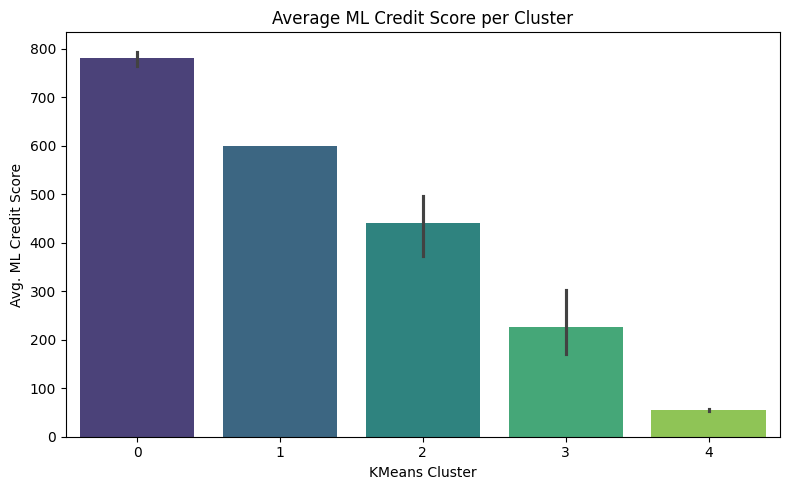

In [21]:

plt.figure(figsize=(8, 5))
sns.barplot(x='cluster', y='ml_credit_score', data=wallet_df, palette="viridis")
plt.title("Average ML Credit Score per Cluster")
plt.xlabel("KMeans Cluster")
plt.ylabel("Avg. ML Credit Score")
plt.tight_layout()
plt.show()


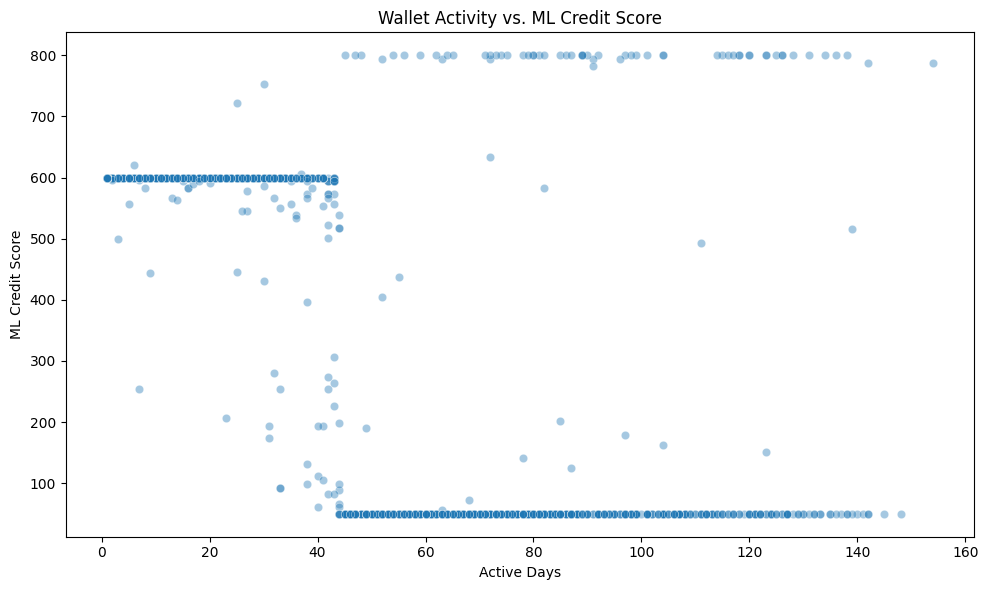

In [20]:

plt.figure(figsize=(10, 6))
sns.scatterplot(x='activity_days', y='ml_credit_score', data=wallet_df, alpha=0.4)
plt.title("Wallet Activity vs. ML Credit Score")
plt.xlabel("Active Days")
plt.ylabel("ML Credit Score")
plt.tight_layout()
plt.show()


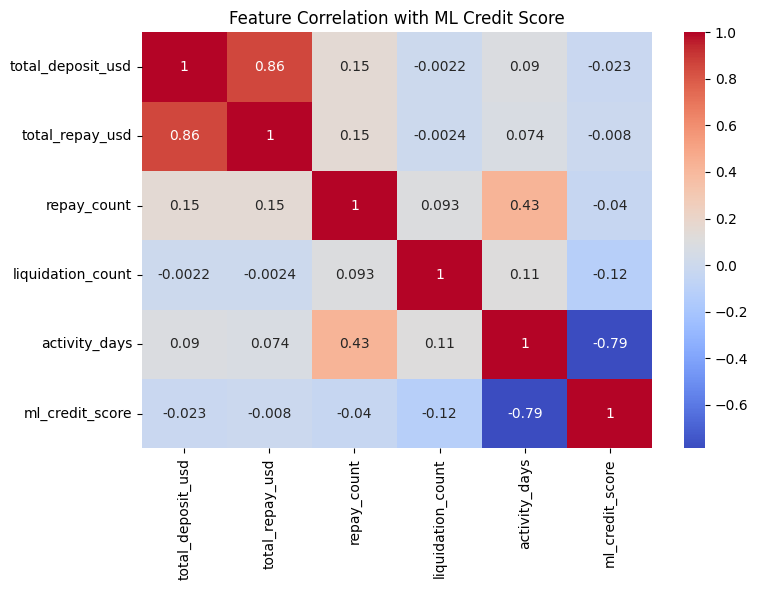

In [19]:

plt.figure(figsize=(8, 6))
sns.heatmap(wallet_df[['total_deposit_usd', 'total_repay_usd', 'repay_count', 'liquidation_count', 'activity_days', 'ml_credit_score']].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation with ML Credit Score")
plt.tight_layout()
plt.show()
